In [1]:
### REMOVE THIS ###

client_id = '9f34a1e09fd78fe'
client_secret = 'e5b4803ba0a010191e3b79143de418cf44949d89'

In [2]:
from collections import namedtuple
Item = namedtuple('Item', 'url id'.split())

In [6]:
import os

def load_queue(dir):
    def append(q, name, files):
        q += [f for f in files if f.endswith('.png')]
    q = []
    os.path.walk(dir, append , q)
    return q

In [4]:
import requests
from imgurpython import ImgurClient
from io import BytesIO

print 'Fetching urls...'
queue = []

client = ImgurClient(client_id, client_secret)
items = client.gallery()
for item in items:
    if item.is_album:
        for img in client.get_album(item.id).images:
            queue.append(Item(img['link'], img['id']))
    else:
        queue.append(Item(item.link, item.id))
print 'done'
            

Fetching urls...
done


In [7]:
import matplotlib.pyplot as plt

import numpy as np

from PIL import Image
from cStringIO import StringIO

In [6]:
import os

if not os.path.exists('raw'):
    os.mkdir('raw')

for n, item in enumerate(queue, 1):
    print '\rDownloading {:.2f}% ({} of {})'.format(float(n) * 100 / len (queue), n, len(queue)),

    r = requests.get(item.url)
    if not r.ok:
        continue

    i = Image.open(BytesIO(r.content))
    i.save('raw/{}.png'.format(item.id))
    

In [7]:
if not os.path.exists('low'):
    os.mkdir('low')

queue = load_queue('raw')
for n, f in enumerate(queue, 1):
    print '\rConverting {:.2f}% ({} of {})'.format(float(n) * 100 / len (queue), n, len(queue)),
    i = Image.open('raw/{}'.format(f))
    i = i.convert('L', dither=False)
    scale = float(500) / max(i.width, i.height)
    i = i.resize((int(i.width * scale), int(i.height * scale)))
    i.save('low/{}'.format(f))

Converting 100.00% (711 of 711)


In [8]:
from collections import defaultdict
from collections import namedtuple

Directions = namedtuple('Directions', 'down right'.split())

markov = defaultdict(lambda: Directions(defaultdict(int), defaultdict(int)))

In [3]:
import json, os

if os.path.exists('markov.json'):
    with open('markov.json', 'r') as f:
        markov = defaultdict(int, {int(state): Directions(*[defaultdict(int, {int(new_state): int(probab)
                   for new_state, probab in transition[direction].items()})
                    for direction in 'right down'.split()])
                      for state, transition in json.loads(f.read()).items()})

In [9]:
def learn_from(f):
    img = np.asarray(Image.open('low/{}'.format(f)))
    w, h = img.shape
    for (i, j), px in np.ndenumerate(img):
        if i + 1 < w:
            markov[px].right[img[i+1][j]] += 1
        if j + 1 < h:
            markov[px].down[img[i][j+1]] += 1

queue = load_queue('low')
for n, i in enumerate(queue, 1):
    learn_from(i)
    print '\rLearning {:.2f}% ({} of {})'.format(float(n) * 100 / len (queue), n, len(queue)),

Learning 100.00% (711 of 711)


In [10]:
import json

with open('markov.json', 'w') as f:
    f.write(json.dumps({str(state): {direction: {str(new_state): str(probab)
                         for new_state, probab in getattr(transition, direction).items()}
                            for direction in 'right down'.split()}
                              for state, transition in markov.items()}))

In [ ]:
import shutil

print 'Cleaning up'

# shutil.rmtree('raw')
# shutil.rmtree('low')

In [12]:
from operator import itemgetter
from collections import OrderedDict

def normalize(transitions):
    m = max(transitions.values())
    probabilities = {state : float(weight) / m for state, weight in transitions.items()}
    
    states, probs = zip(*sorted(probabilities.items(), key=itemgetter(1)))
    slots = np.cumsum(probs)
    normalized = [s / max(slots) for s in slots]
    distribution = OrderedDict(zip(normalized, states))
    return distribution

normalized = {s: Directions(*map(normalize, d)) for s, d in markov.items()} 

In [13]:
def dump(name, transitions):
    for d in 'right down'.split():
        with open(name+'_'+d+'.txt', 'w') as f:
            for px in transitions.keys():
                f.write(str(px) + '->' + ' '.join(map(repr, sorted(getattr(transitions[px], d).items())))+'\n')

dump('markov', markov)
dump('normalized', normalized)

In [14]:
import random

def pick_from(distribution):
    prob = distribution.keys()
    i, bin = random.random(), 0
    
    for s, t in zip(prob, prob[1:]):
        bin = s
        if s >= i:
            break
            
    return distribution[bin]

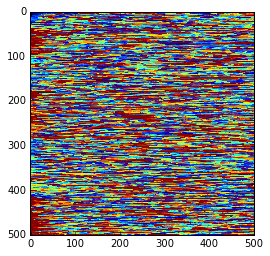

In [15]:
from itertools import product

matrix = np.zeros((500, 500), np.uint8)
seed =  random.choice(markov.keys()) # seed
matrix[0][0] = seed

for i, j in product(range(499), range(499)):
    px = matrix[i][j]
    matrix[i][j+1] = pick_from(normalized[px].right)
    matrix[i+1][j] = pick_from(normalized[px].down)

import scipy.misc
scipy.misc.imsave('outfile.jpg', matrix)

%matplotlib inline
plt.imshow(matrix)

In [ ]:
' '.join(map(repr, sorted(normalized.keys())))